<a href="https://colab.research.google.com/github/ang-bill/IU-DLMDSME01-Credit-Card-Fraud-Detection/blob/main/Task1_Credit_Card_Fraud_Detection_Classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2. Classifier 1

## Section 2A. Retrieve Dataset from Kaggle Hub
At the first run, the dataset is downloaded from Kaggle and stored locally. Subsequent runs check whether the file already exists.
See: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


In [2]:
import os
import pandas as pd # Pandas dataframe
import kagglehub # Kagglehub to access dataset
import shutil # Util for copying files
from google.colab import drive # Import Google Drive utilities

# Mount Google Drive for persistent storage
drive.mount('/content/drive')
local_storage_base_dir = "/content/drive/MyDrive/Colab_Kaggle_Data"

# Dataset details
kaggle_dataset_id = "mlg-ulb/creditcardfraud"
file_name_in_dataset = "creditcard.csv"

# Construct the full path to locally stored dataset
local_dataset_dir = os.path.join(local_storage_base_dir, *kaggle_dataset_id.split('/'))
full_local_file_path = os.path.join(local_dataset_dir, file_name_in_dataset)

# Ensure the desired local storage directory exists
os.makedirs(local_dataset_dir, exist_ok=True)

df = None # Initialize pandas df

# Check if the file already exists in local storage, otherwise download from Kaggle
if os.path.exists(full_local_file_path):
    print(f"'{file_name_in_dataset}' found locally at '{full_local_file_path}'. Loading from there.")
else:
    print(f"'{file_name_in_dataset}' not found locally. Attempting to download from KaggleHub and store it.")

    # Use kagglehub.dataset_download to get the dataset.
    downloaded_source_root = kagglehub.dataset_download(kaggle_dataset_id)

    # Construct the path to the file within the KaggleHub download location
    source_file_path = os.path.join(downloaded_source_root, file_name_in_dataset)

    if os.path.exists(source_file_path):
        print(f"Dataset found at KaggleHub resolved location: '{source_file_path}'.")
        print(f"Copying '{file_name_in_dataset}' to local path: '{full_local_file_path}'.")

        # Copy the file to local storage location
        shutil.copy(source_file_path, full_local_file_path)

    else:
        raise FileNotFoundError(f"Failed to find '{file_name_in_dataset}' at source '{source_file_path}' after KaggleHub download resolution.")

# Load the dataset into a pandas dataframe
df = pd.read_csv(full_local_file_path)


Mounted at /content/drive
'creditcard.csv' found locally at '/content/drive/MyDrive/Colab_Kaggle_Data/mlg-ulb/creditcardfraud/creditcard.csv'. Loading from there.


## Section 2B. Implementation of Classifier - Base


### 1. Install dependencies
(not included in default Colab Notebook)

In [3]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 8.1 MB/s eta 0:00:00


### 2. Customised Class on Feature Engineering

#### HourExtractor

In [4]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class HourExtractor(BaseEstimator, TransformerMixin):
    """Extracts 'Hour' from 'Time' feature to capture diurnal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Convert seconds to hour of day (0-23)
        X_copy['Hour'] = (X_copy['Time'] % (60*60*24)) // (60*60)

        #return X_copy.drop(columns=['Time']) # Replace Time with Hour
        return X_copy

#### DayNightExtractor

In [5]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DayNightExtractor(BaseEstimator, TransformerMixin):
    """Extracts 'Is_Night' from 'Time' feature to capture diurnal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Convert seconds to hour of day (0-23)
        #X_copy['Hour'] = (X_copy['Time'] % (60*60*24)) // (60*60)

        # Is_Night (Binary): 1 if between 24:00 and 08:00 (convert to hours first)
        X_copy['Is_Night'] = (((X_copy['Time'] % (60*60*24)) // (60*60)) <= 8)
        X_copy['Is_Night'] = X_copy['Is_Night'].astype(int)

        return X_copy

#### LogAmountExtractor

In [6]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LogAmountExtractor(BaseEstimator, TransformerMixin):
    """Extracts Log Amount from Amount to handle the extreme skew
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Log Amount: Handles the extreme skew of transaction amounts
        # np.log1p avoids log(0) errors
        X_copy['Log_Amount'] = np.log1p(X_copy['Amount'])

        return X_copy

#### V14V17InteractionExtractor

In [7]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class V14V17InteractionExtractor(BaseEstimator, TransformerMixin):
    """Extracts a combined feature from V14 and V17 to capture diagonal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Log Amount: Handles the extreme skew of transaction amounts
        # np.log1p avoids log(0) errors
        X_copy['V14_V17'] = X_copy['V14'] * X_copy['V17']

        return X_copy

### 3. Customised Class on Probability Calibration
A customised classifier applies analytical probability calibration according to Dal Pozzolo et al. (2025). This approach enables integration with the scikit-learn library.

https://doi.org/10.1109/SSCI.2015.33

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
import numpy as np

class PozzoloCalibratedClassifier(BaseEstimator, ClassifierMixin):
    """
    Wraps a classifier to apply Dal Pozzolo's prior correction automatically
    during prediction.

    Parameters
    ----------
    estimator : object
        The base classifier (e.g., LogisticRegression or XGBClassifier).
    original_prior : float
        The prevalence of the positive class in the original dataset (e.g., 0.00172).
    sampling_ratio : float, default=1.0
        The target ratio used in RandomUnderSampler (1.0 means 50/50).
    """

    _estimator_type = "classifier"

    def __init__(self, estimator, original_prior=0.00172, sampling_ratio=1.0):
        self.estimator = estimator
        self.original_prior = original_prior
        self.sampling_ratio = sampling_ratio

    def fit(self, X, y):
        # Fit the internal model on the data provided (which is already RUS-sampled)
        self.estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        check_is_fitted(self.estimator)

        # 1. Get Biased Probabilities (P_s) from the internal model
        # The model thinks the world is 50% fraud because of RUS
        probs_biased = self.estimator.predict_proba(X)

        # If we only have 1 class in test (edge case), return as is
        if probs_biased.shape[1] != 2:
            return probs_biased

        p_s = probs_biased[:, 1]

        # 2. Calculate Correction Factor (Gamma)
        # Gamma = (Original_Odds) / (Sampled_Odds)
        # Sampled_Odds for ratio 1.0 is 0.5/0.5 = 1
        prior_s = self.sampling_ratio / (1 + self.sampling_ratio) # e.g. 0.5

        # Edge case protection
        if self.original_prior <= 0 or self.original_prior >= 1:
            return probs_biased

        gamma = (self.original_prior / (1 - self.original_prior)) / \
                (prior_s / (1 - prior_s))

        # 3. Apply Formula
        p_calib = (gamma * p_s) / (gamma * p_s + (1 - p_s))

        # Return in Scikit-Learn format [P(0), P(1)]
        return np.vstack([1 - p_calib, p_calib]).T

    def predict(self, X):
        # This is the Key: predict() now uses the CALIBRATED probability
        # So F2 Score optimization sees the real-world performance
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

    def get_params(self, deep=True):
        # Necessary for RandomizedSearchCV to access the inner 'estimator' params
        params = super().get_params(deep)
        if deep and hasattr(self.estimator, 'get_params'):
            for key, value in self.estimator.get_params().items():
                params[f'estimator__{key}'] = value
        return params

### 3. Customised Class TOS Generator for XGBOD

In [9]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.base import BaseEstimator, TransformerMixin

class TOSGenerator(BaseEstimator, TransformerMixin):
    """
    Generates Transformed Outlier Scores (TOS) for XGBOD.
    Wraps PyOD unsupervised detectors to act as feature extractors.
    """
    def __init__(self, detectors=None):
        self.detectors = detectors

    def fit(self, X, y=None):
        # If no detectors provided, initialize default ones
        # Note: We initialize here to ensure fresh models for every fold
        if self.detectors is None:
            self.detectors = [KNN(n_neighbors=5), LOF(n_neighbors=5)]

        for detector in self.detectors:
            detector.fit(X)
        return self

    def transform(self, X):
        tos_features = []
        for detector in self.detectors:
            # For PyOD, decision_function returns the anomaly score
            # Reshape to (n_samples, 1)
            scores = detector.decision_function(X).reshape(-1, 1)
            tos_features.append(scores)

        # Stack original features with new TOS features
        return np.hstack([X] + tos_features)

### 4. Required Packages

In [10]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.preprocessing import RobustScaler
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as ImbPipeline # Supports resampling inside CV
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import loguniform

# Visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import warnings
# Filter specific warning from imblearn pipeline (supress as pipeline works correctly)
warnings.filterwarnings("ignore", category=FutureWarning, module="imblearn.pipeline")

### 5. Configuration of pipelines
The ablation study evaluates the effect of each component separately, therefore distinct pipelines are defined.

**Components:**
*   Feature engineering: Augmentation with Hour vs. no feature engineering
*   Data preprocessing: RobustScaler vs. no scaling
*   Resampling: RUS vs. no resampling
*   Classifier optimisation: Randomised parameter optimisation vs. using default parameters





In [11]:
# We define distinct pipelines to test each component
configs = {
    "1. Naive (No Preproc)": {
        'scale': False, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'rus': False, 'opt': False
    },
    "2. + Scaling (Robust)": {
        'scale': True, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.1 + Feature Eng (Hour)": {
        'scale': True, 'fe_1': True, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.2 + Feature Eng (DayNight)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.3 + Feature Eng (LogAmount)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.4 + Feature Eng (V14-V17-Interaction)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': False, 'opt': False
    },
    "4. + RUS (Calibrated)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': True, 'opt': False
    },
    "5.A + Optimization (with RUS)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': True, 'opt': True
    },
    "5.B + Optimization (without RUS)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': False, 'opt': True
    }
}

### 6. Create features and labels

In [12]:
# --- SETUP: Synthetic Data mimicking your EDA findings ---
#from sklearn.datasets import make_classification
# We generate data with 'Time' (0-172800 seconds) and 'Amount' features
#N_SAMPLES = 5000
#X, y = make_classification(n_samples=N_SAMPLES, n_features=28, n_informative=20,
#                           weights=[0.99828, 0.00172], # 0.172% minority
#                           random_state=42)

# Create DataFrame to simulate real columns
#cols = [f'V{i}' for i in range(1, 29)]
#df_X = pd.DataFrame(X, columns=cols)
# Add 'Time' (0 to 48 hours in seconds) and 'Amount' (with outliers)
#df_X['Time'] = np.random.randint(0, 172800, size=N_SAMPLES)
#df_X['Amount'] = np.random.exponential(scale=100, size=N_SAMPLES)
#X = df_X # Use DataFrame for the pipeline
X = df.drop('Class', axis=1)  # features
y = df['Class'] # Labels
original_fraud_rate = np.mean(y)

print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Dataset Shape: {X.shape}, Fraud Ratio: {np.mean(y):.4}")

2025-12-11 13:56:15 Dataset Shape: (284807, 30), Fraud Ratio: 0.001727


### 7. Run Ablation Study (Train, Validate, and Test)

In [13]:
def run_ablation_study(experiment_name, base_clf, param_dist, X, y, configs, extra_pipeline_steps=None):
    """
    Runs the full ablation study for a specific classifier.

    Parameters:
    - experiment_name: String label (e.g., "XGBoost")
    - base_clf: The instantiated classifier object (e.g., XGBClassifier())
    - param_dist: Dictionary for RandomizedSearchCV
    - X, y: Data
    - configs: Dictionary of ablation configurations
    - extra_pipeline_steps: List of (name, transformer) tuples to add before scaling (e.g., TOS)
    """

    # Cross Validation Outer Loop: Repeated Stratified 5-Fold
    #outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    # Cross Validation Inner Loop: Stratified 4-Fold (used inside RandomizedSearchCV)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    results_table = []
    plotting_data = {}

    print(f"--- Starting Experiment: {experiment_name} ---")

    for name, cfg in configs.items():
        print(f"\n{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Running Configuration: {name}")

        fold_metrics = {
                'f2_test': [], 'f2_train': [],
                'f1_test': [], 'f1_train': [],
                'rec_test': [], 'rec_train': [],
                'prec_test': [], 'prec_train': [],
                'best_params': []
            }
        plotting_data[name] = {'y_real': [], 'y_proba': []}

        # Outer CV loop (split training and test set)
        for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # --- A. Build Pipeline Steps ---
            steps = []

            # 1. Feature Engineering
            #if cfg['fe']:
                #steps.append(('fe', HourExtractor()))
                #steps.append(('fe', FraudFeatureEngineer()))
            if cfg['fe_1']:
                steps.append(('fe_1', HourExtractor()))
            if cfg['fe_2']:
                steps.append(('fe_2', DayNightExtractor()))
            if cfg['fe_3']:
                steps.append(('fe_3', LogAmountExtractor()))
            if cfg['fe_4']:
                steps.append(('fe_4', V14V17InteractionExtractor()))


            # 1b. Extra Steps (e.g., XGBOD TOS Generator)
            if extra_pipeline_steps:
                steps.extend(extra_pipeline_steps)

            # 2. Scaling (RobustScaler)
            if cfg['scale']:
                # Apply robust scaler to Amount, pass through others
                # @TODO
                # Note: For simplicity in this demo, we apply to all numericals coming out of previous step
                steps.append(('scaler', RobustScaler()))

            # 3. Resampling (RUS)
            # Resampling in the pipeline preventes data leakage
            # Resampling is only applied to the traning fold inside
            # (https://imbalanced-learn.org/stable/common_pitfalls.html)
            if cfg['rus']:
                steps.append(('rus', RandomUnderSampler(sampling_strategy=1.0, random_state=42)))

            # 4. Classifier
            # SciKit-Learn LogisticRegression
            # (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
            # Regularization is applied by default
            # Solver liblinear: supports L1 and L2 regularization
            if cfg['rus']:
                  #base_clf = LogisticRegression(solver='liblinear', random_state=42)
                  #final_clf = PozzoloCalibratedClassifier(
                  #    estimator=base_clf,
                  #    original_prior=original_fraud_rate,
                  #    sampling_ratio=1.0
                  #)
                  # Wrap with Pozzolo Calibration
                  final_clf = PozzoloCalibratedClassifier(
                      estimator=clone(base_clf), # clone base_clf to ensure fresh start
                      original_prior=original_fraud_rate,
                      sampling_ratio=1.0
                  )
            else:
                  #final_clf = LogisticRegression(solver='liblinear', random_state=42)
                  final_clf = clone(base_clf)

            steps.append(('clf', final_clf))

            # Create pipeline from steps
            pipeline = ImbPipeline(steps)

            # --- B. Optimization (Inner Loop) ---
            if cfg['opt']:
                # Inner CV for optimisation
                # (CV uses a fold of the train set for validation)
                # Optimize for F2 Score

                # Define distribution of the tuneable parameters
                # print(clf.get_params()) # Print tunable parameters
                # Naming convention of parameter names: stepname__parameter
                # Here, the clf, the classifier of the pipeline is tuned
                #clf_param_name = 'clf__estimator__C' if cfg['rus'] else 'clf__C'
                #param_dist = {
                #    clf_param_name: loguniform(1e-4, 1e2) # Inverse of regularization strength
                #}

                iterations = 50 if cfg['rus'] else 15

                # Adjust param names for wrapper vs standalone
                # If wrapped: clf__estimator__param
                # If standalone: clf__param
                prefix = 'clf__estimator__' if cfg['rus'] else 'clf__'

                # Update param_dist keys to match current pipeline structure
                tuned_params = {f"{prefix}{k}": v for k, v in param_dist.items()}

                search = RandomizedSearchCV(pipeline, tuned_params,
                                            n_iter=iterations,
                                            scoring=make_scorer(fbeta_score, beta=2),
                                            cv=inner_cv, n_jobs=-1,
                                            random_state=42)
                search.fit(X_train, y_train)
                model = search.best_estimator_
            else:
                pipeline.fit(X_train, y_train)
                model = pipeline

            # Prediction on test set
            y_pred_test = model.predict(X_test)

            # Store probabilities for visualisation
            y_proba_test = model.predict_proba(X_test)[:, 1] # calibrated probabilities
            plotting_data[name]['y_real'].append(y_test)
            plotting_data[name]['y_proba'].append(y_proba_test)

            # Prediction also on training set
            # This enables the measurement of the generalization gap between
            # the training and the test accuracy to control overfitting. See
            # https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
            # Test metrics: measures performance on test data (never seen by model)
            # Training metrics: measures performance on training data (all inner
            #                   folds of CV)
            y_pred_train = model.predict(X_train)

            # Record Metrics on test set
            fold_metrics['f2_test'].append(fbeta_score(y_test, y_pred_test, beta=2))
            fold_metrics['f1_test'].append(f1_score(y_test, y_pred_test))
            fold_metrics['rec_test'].append(recall_score(y_test, y_pred_test))
            fold_metrics['prec_test'].append(precision_score(y_test, y_pred_test, zero_division=0))

            # Record Metrics on training set
            fold_metrics['f2_train'].append(fbeta_score(y_train, y_pred_train, beta=2))
            fold_metrics['f1_train'].append(f1_score(y_train, y_pred_train))
            fold_metrics['rec_train'].append(recall_score(y_train, y_pred_train))
            fold_metrics['prec_train'].append(precision_score(y_train, y_pred_train, zero_division=0))

            # Record best optimization parameters
            if cfg['opt']and len(fold_metrics['best_params']) > 0 :
              fold_metrics['best_params'].append(search.best_params_)
              #params_df = pd.DataFrame(search.best_params_)
              #print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
              print(pd.DataFrame(search.best_params_).to_markdown(index=False))

        # --- Aggregate results for this configuration ---
        row = {'Configuration': name}
        metrics_map = {
          'f2': 'F2 Score',
          'f1': 'F1 Score',
          'rec': 'Recall',
          'prec': 'Precision'
          }

        for key, label in metrics_map.items():
          # 1. Get Lists
          test_scores = fold_metrics[f'{key}_test']
          train_scores = fold_metrics[f'{key}_train']

          # 2. Calculate Stats
          test_mean = np.mean(test_scores)
          test_std  = np.std(test_scores)
          train_mean = np.mean(train_scores)

          # 3. Calculate Gap (Train - Test)
          gap = train_mean - test_mean

          # 4. Calculate Percentages (Safe Division)
          if test_mean > 0:
              cv_pct = (test_std / test_mean) * 100       # Coefficient of Variation
              gap_pct = (gap / test_mean) * 100           # Relative Overfitting
          else:
              cv_pct = 0.0
              gap_pct = 0.0

          # 5. Add Columns to Row
          row[f'{label} (Mean)'] = f"{test_mean:.4f}"
          #row[f'{label} (SD)']   = f"{test_std:.4f} ({cv_pct:.1f}%)"
          row[f'{label} (SD)']   = f"{test_std:.4f}"
          row[f'{label} (SD%)']   = f"{cv_pct:.1f}"
          #row[f'{label} (Gap)']  = f"{gap:.4f} ({gap_pct:.1f}%)"
          row[f'{label} (Gap)']   = f"{gap:.4f}"
          row[f'{label} (Gap%)']   = f"{gap_pct:.1f}"


        # Add hyperparameters

        # Extract all C values found - key 'clf__estimator__C'
        #C_values_found = []
        #for params in fold_metrics['best_params']:
        #    if 'clf__estimator__C' in params:
        #        C_value = params['clf__estimator__C']
        #        C_values_found.append(C_value)

        # Calculate mean and sd for hyperparameters
        params_df = pd.DataFrame(fold_metrics['best_params'])
        numeric_params_df = params_df.select_dtypes(include=[np.number])
        mean_params = numeric_params_df.mean()
        sd_params = numeric_params_df.std(ddof=1) # Use ddof=1 for sample SD

        for param_name in mean_params.index:
            mean_val = mean_params[param_name]
            sd_val = sd_params[param_name]

            # Use a clean, generic column name (e.g., C_Mean)
            base_name = param_name.split('__')[-1] # Extracts 'C' from 'clf__C'

            row[f'{base_name} (Mean)'] = f"{mean_val:.4f}"
            row[f'{base_name} (SD)'] = f"{sd_val:.4f}"

        # 5. Append the complete row to the results table
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        print(pd.DataFrame([row]).to_markdown(index=False))
        results_table.append(row)

    # --- Return result ---
    return pd.DataFrame(results_table), plotting_data

### 8. Precision - Recall - AUC

In [20]:
def plot_pr_curves_with_std(plotting_data, title="Precision-Recall Curve Comparison"):
    """
    Plots the Mean Precision-Recall Curve with Standard Deviation shading.
    """
    plt.figure(figsize=(10, 8))

    # Iterate over each configuration (e.g., "Naive", "XGBoost + RUS", etc.)
    for name, data in plotting_data.items():
        y_real_folds = data['y_real']
        y_proba_folds = data['y_proba']

        # We will interpolate precision at these fixed recall points
        mean_recall = np.linspace(0, 1, 100)
        precisions = []

        # Process every fold
        for y_true, y_scores in zip(y_real_folds, y_proba_folds):
            # Calculate PR curve for this fold
            precision, recall, _ = precision_recall_curve(y_true, y_scores)

            # Interpolate precision to match the fixed mean_recall grid
            # Note: PR curve is usually plotted Recall (x) vs Precision (y)
            # We reverse arguments for interp because recall is decreasing in the raw output
            interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interp_precision)

        # Convert to array for stats
        precisions = np.array(precisions)

        # Calculate Mean and SD
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Calculate Mean AUC (Area Under Curve) - Average Precision
        mean_auc = auc(mean_recall, mean_precision)

        # --- PLOTTING ---
        p = plt.plot(mean_recall, mean_precision,
                     label=f"{name} (AUC = {mean_auc:.3f})",
                     linewidth=2, alpha=0.9)

        # Add Shading for Standard Deviation (Robustness)
        plt.fill_between(mean_recall,
                         np.maximum(mean_precision - std_precision, 0),
                         np.minimum(mean_precision + std_precision, 1),
                         color=p[0].get_color(), alpha=0.15)

    # Decoration
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 0.15), loc='upper center', ncol= 2, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])

    # Add baseline (No Skill)
    # Fraud Ratio ~ 0.0017
    no_skill = 0.00172
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label='No Skill (Baseline)')

    plt.tight_layout()
    plt.show()

## Section 2C. Implementation of Base Classifier - Logistic Regression


--- Starting Experiment: Logistic Regression ---

2025-12-11 13:56:22 Running Configuration: 1. Naive (No Preproc)
2025-12-11 13:56:34

| Configuration         |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc) |            0.6101 |         

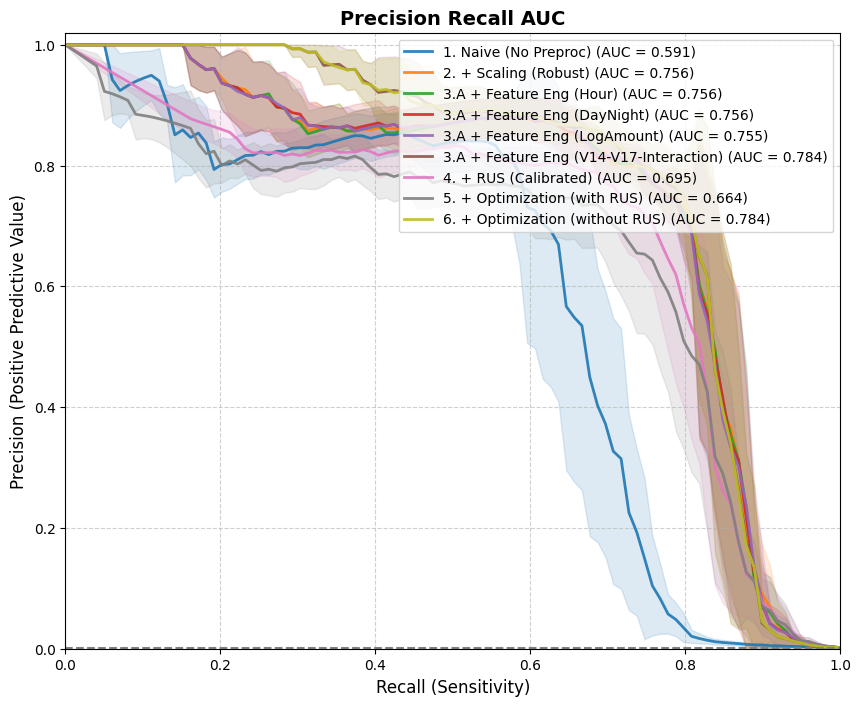

In [15]:
from scipy.stats import loguniform

lr_params = {'C': loguniform(1e-4, 1e2)}

df_results, plot_data = run_ablation_study(
    experiment_name="Logistic Regression",
    base_clf=LogisticRegression(solver='liblinear', random_state=42),
    param_dist=lr_params,
    X=X, y=y, configs=configs
)

# Metrics table
print("\n=== Ablation Study Results (Baseline: Logistic Regression) ===")
print(df_results.to_markdown(index=False))

# Precision Recall AUC
plot_pr_curves_with_std(plot_data, title="Precision Recall AUC (Baseline: Logistic Regression)")

2025-12-11 Config version 4, 1 repeat

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc)                   |            0.6101 |          0.0708 |             11.6 |           0.0217 |               3.6 |            0.6614 |          0.0504 |              7.6 |           0.0215 |               3.2 |          0.5813 |        0.0815 |           14   |         0.0208 |             3.6 |             0.7806 |           0.045  |               5.8 |            0.0115 |                1.5 |
| 2. + Scaling (Robust)                   |            0.6607 |          0.0378 |              5.7 |           0.006  |               0.9 |            0.729  |          0.0324 |              4.5 |           0.0056 |               0.8 |          0.6221 |        0.0408 |            6.6 |         0.006  |             1   |             0.8827 |           0.0329 |               3.7 |            0.0021 |                0.2 |
| 3.A + Feature Eng (Hour)                |            0.657  |          0.0329 |              5   |           0.0098 |               1.5 |            0.7261 |          0.0292 |              4   |           0.0087 |               1.2 |          0.618  |        0.0351 |            5.7 |         0.0101 |             1.6 |             0.8821 |           0.0329 |               3.7 |            0.0033 |                0.4 |
| 3.A + Feature Eng (DayNight)            |            0.6608 |          0.0326 |              4.9 |           0.0105 |               1.6 |            0.7292 |          0.0287 |              3.9 |           0.0089 |               1.2 |          0.622  |        0.0351 |            5.6 |         0.0111 |             1.8 |             0.8828 |           0.0328 |               3.7 |            0.0022 |                0.2 |
| 3.A + Feature Eng (LogAmount)           |            0.6608 |          0.0316 |              4.8 |           0.01   |               1.5 |            0.7292 |          0.0286 |              3.9 |           0.0083 |               1.1 |          0.6221 |        0.0336 |            5.4 |         0.0106 |             1.7 |             0.8827 |           0.0334 |               3.8 |            0.0015 |                0.2 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 |          0.0201 |              2.8 |           0.0128 |               1.7 |            0.7692 |          0.0169 |              2.2 |           0.0141 |               1.8 |          0.7073 |        0.0264 |            3.7 |         0.0117 |             1.6 |             0.8455 |           0.042  |               5   |            0.0148 |                1.7 |
| 4. + RUS (Calibrated)                   |            0.7377 |          0.0439 |              5.9 |          -0.0017 |              -0.2 |            0.6662 |          0.0895 |             13.4 |          -0.0067 |              -1   |          0.8008 |        0.0206 |            2.6 |         0.004  |             0.5 |             0.5839 |           0.1427 |              24.4 |           -0.0107 |               -1.8 |
| 5. + Optimization (with RUS)            |            0.7339 |          0.044  |              6   |          -0.0007 |              -0.1 |            0.6829 |          0.0841 |             12.3 |          -0.0049 |              -0.7 |          0.7764 |        0.0144 |            1.9 |         0.0031 |             0.4 |             0.6207 |           0.1358 |              21.9 |           -0.0091 |               -1.5 |
| 6. + Optimization (without RUS)         |            0.7289 |          0.0183 |              2.5 |           0.0151 |               2.1 |            0.7679 |          0.0161 |              2.1 |           0.0162 |               2.1 |          0.7053 |        0.0244 |            3.5 |         0.0142 |             2   |             0.8451 |           0.0422 |               5   |            0.0163 |                1.9 |


2025-12-11 Config version 4, 1 repeat

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) | F2 Score (SD)   | F2 Score (Gap)   |   F1 Score (Mean) | F1 Score (SD)   | F1 Score (Gap)   |   Recall (Mean) | Recall (SD)    | Recall (Gap)   |   Precision (Mean) | Precision (SD)   | Precision (Gap)   |
|:----------------------------------------|------------------:|:----------------|:-----------------|------------------:|:----------------|:-----------------|----------------:|:---------------|:---------------|-------------------:|:-----------------|:------------------|
| 1. Naive (No Preproc)                   |            0.6101 | 0.0708 (11.6%)  | 0.0217 (3.6%)    |            0.6614 | 0.0504 (7.6%)   | 0.0215 (3.2%)    |          0.5813 | 0.0815 (14.0%) | 0.0208 (3.6%)  |             0.7806 | 0.0450 (5.8%)    | 0.0115 (1.5%)     |
| 2. + Scaling (Robust)                   |            0.6607 | 0.0378 (5.7%)   | 0.0060 (0.9%)    |            0.729  | 0.0324 (4.5%)   | 0.0056 (0.8%)    |          0.6221 | 0.0408 (6.6%)  | 0.0060 (1.0%)  |             0.8827 | 0.0329 (3.7%)    | 0.0021 (0.2%)     |
| 3.A + Feature Eng (Hour)                |            0.657  | 0.0329 (5.0%)   | 0.0098 (1.5%)    |            0.7261 | 0.0292 (4.0%)   | 0.0087 (1.2%)    |          0.618  | 0.0351 (5.7%)  | 0.0101 (1.6%)  |             0.8821 | 0.0329 (3.7%)    | 0.0033 (0.4%)     |
| 3.A + Feature Eng (DayNight)            |            0.6608 | 0.0326 (4.9%)   | 0.0105 (1.6%)    |            0.7292 | 0.0287 (3.9%)   | 0.0089 (1.2%)    |          0.622  | 0.0351 (5.6%)  | 0.0111 (1.8%)  |             0.8828 | 0.0328 (3.7%)    | 0.0022 (0.2%)     |
| 3.A + Feature Eng (LogAmount)           |            0.6608 | 0.0316 (4.8%)   | 0.0100 (1.5%)    |            0.7292 | 0.0286 (3.9%)   | 0.0083 (1.1%)    |          0.6221 | 0.0336 (5.4%)  | 0.0106 (1.7%)  |             0.8827 | 0.0334 (3.8%)    | 0.0015 (0.2%)     |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 | 0.0201 (2.8%)   | 0.0128 (1.7%)    |            0.7692 | 0.0169 (2.2%)   | 0.0141 (1.8%)    |          0.7073 | 0.0264 (3.7%)  | 0.0117 (1.6%)  |             0.8455 | 0.0420 (5.0%)    | 0.0148 (1.7%)     |
| 4. + RUS (Calibrated)                   |            0.7377 | 0.0439 (5.9%)   | -0.0017 (-0.2%)  |            0.6662 | 0.0895 (13.4%)  | -0.0067 (-1.0%)  |          0.8008 | 0.0206 (2.6%)  | 0.0040 (0.5%)  |             0.5839 | 0.1427 (24.4%)   | -0.0107 (-1.8%)   |
| 5. + Optimization (with RUS)            |            0.7339 | 0.0440 (6.0%)   | -0.0007 (-0.1%)  |            0.6829 | 0.0841 (12.3%)  | -0.0049 (-0.7%)  |          0.7764 | 0.0144 (1.9%)  | 0.0031 (0.4%)  |             0.6207 | 0.1358 (21.9%)   | -0.0091 (-1.5%)   |
| 6. + Optimization (without RUS)         |            0.7289 | 0.0183 (2.5%)   | 0.0151 (2.1%)    |            0.7679 | 0.0161 (2.1%)   | 0.0162 (2.1%)    |          0.7053 | 0.0244 (3.5%)  | 0.0142 (2.0%)  |             0.8451 | 0.0422 (5.0%)    | 0.0163 (1.9%)     |

2025-11-09 (5 repeat):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.6195 |          0.0538 |            0.6599 |          0.0434 |             0.5959 |           0.0615 |                0.7465 |              0.0574 |
| 2. + Scaling (Robust)                   |            0.6569 |          0.0464 |            0.7238 |          0.0364 |             0.6191 |           0.0516 |                0.8756 |              0.0299 |
| 3.A + Feature Eng (Hour)                |            0.6576 |          0.0444 |            0.7249 |          0.0344 |             0.6195 |           0.0496 |                0.8778 |              0.0297 |
| 3.A + Feature Eng (DayNight)            |            0.6561 |          0.0455 |            0.7228 |          0.0369 |             0.6183 |           0.05   |                0.8738 |              0.0317 |
| 3.A + Feature Eng (LogAmount)           |            0.6599 |          0.046  |            0.7268 |          0.038  |             0.622  |           0.0501 |                0.8778 |              0.0329 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.734  |          0.0326 |            0.7718 |          0.027  |             0.711  |           0.0378 |                0.8463 |              0.0382 |


2025-11-09 (only 1 repeat):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.6101 |          0.0708 |            0.6614 |          0.0504 |             0.5813 |           0.0815 |                0.7806 |              0.045  |
| 2. + Scaling (Robust)                   |            0.6607 |          0.0378 |            0.729  |          0.0324 |             0.6221 |           0.0408 |                0.8827 |              0.0329 |
| 3.A + Feature Eng (Hour)                |            0.657  |          0.0329 |            0.7261 |          0.0292 |             0.618  |           0.0351 |                0.8821 |              0.0329 |
| 3.A + Feature Eng (DayNight)            |            0.6608 |          0.0326 |            0.7292 |          0.0287 |             0.622  |           0.0351 |                0.8828 |              0.0328 |
| 3.A + Feature Eng (LogAmount)           |            0.6608 |          0.0316 |            0.7292 |          0.0286 |             0.6221 |           0.0336 |                0.8827 |              0.0334 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 |          0.0201 |            0.7692 |          0.0169 |             0.7073 |           0.0264 |                0.8455 |              0.042  |

2025-11-06 with PozzoloCalibratedClassifier (after code changes):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |   Best Params (Mean) |   Best Params (SD) |
|:-------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|---------------------:|-------------------:|
| 1. Naive (No Preproc)    |            0.6195 |          0.0538 |            0.6599 |          0.0434 |             0.5959 |           0.0615 |                0.7465 |              0.0574 |             nan      |           nan      |
| 2. + Scaling (Robust)    |            0.6569 |          0.0464 |            0.7238 |          0.0364 |             0.6191 |           0.0516 |                0.8756 |              0.0299 |             nan      |           nan      |
| 3. + Feature Eng (Hour)  |            0.6576 |          0.0444 |            0.7249 |          0.0344 |             0.6195 |           0.0496 |                0.8778 |              0.0297 |             nan      |           nan      |
| 4. + RUS (Calibrated)    |            0.6978 |          0.0669 |            0.5995 |          0.1059 |             0.7967 |           0.0586 |                0.4988 |              0.1465 |             nan      |           nan      |
| 5. + Optimization (Full) |            0.7008 |          0.0582 |            0.6215 |          0.0894 |             0.774  |           0.0573 |                0.5343 |              0.1329 |               0.5219 |             0.2571 |


2025-11-06 with PozzoloCalibratedClassifier :

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            | F2 Score (Mean ± SD)   |   F1 Score |   Recall |   Precision |
|:-------------------------|:-----------------------|-----------:|---------:|------------:|
| 1. Naive (No Preproc)    | 0.6195 ± 0.0538        |     0.6599 |   0.5959 |      0.7465 |
| 2. + Scaling (Robust)    | 0.6569 ± 0.0464        |     0.7238 |   0.6191 |      0.8756 |
| 3. + Feature Eng (Hour)  | 0.6576 ± 0.0444        |     0.7249 |   0.6195 |      0.8778 |
| 4. + RUS (Calibrated)    | 0.6978 ± 0.0669        |     0.5995 |   0.7967 |      0.4988 |
| 5. + Optimization (Full) | 0.7008 ± 0.0582        |     0.6215 |   0.774  |      0.5343 |


2025-11-06 without PozzoloCalibratedClassifier:


```
Dataset Shape: (284807, 30), Fraud Ratio: 0.1727%
Starting Ablation Study (this may take a moment)...
Running Configuration: 1. Naive (No Preproc)
Running Configuration: 2. + Scaling (Robust)
Running Configuration: 3. + Feature Eng (Hour)
Running Configuration: 4. + RUS (Calibrated)
Running Configuration: 5. + Optimization (Full)
```


=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            | F2 Score (Mean ± SD)   |   F1 Score |   Recall |   Precision |
|:-------------------------|:-----------------------|-----------:|---------:|------------:|
| 1. Naive (No Preproc)    | 0.6195 ± 0.0538        |     0.6599 |   0.5959 |      0.7465 |
| 2. + Scaling (Robust)    | 0.6569 ± 0.0464        |     0.7238 |   0.6191 |      0.8756 |
| 3. + Feature Eng (Hour)  | 0.6576 ± 0.0444        |     0.7249 |   0.6195 |      0.8778 |
| 4. + RUS (Calibrated)    | 0.6978 ± 0.0669        |     0.5995 |   0.7967 |      0.4988 |
| 5. + Optimization (Full) | 0.6052 ± 0.0515        |     0.6251 |   0.5946 |      0.6721 |

## Section 2D. Implementation of Classifier 1 - XGBoost


In [ ]:
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier

# XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

# Params version 1
xgb_params_v1 = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': loguniform(0.01, 0.3)
}

# Params version 2
xgb_params_v2 = {
    'scale_pos_weight': randint(10, 101),  # Range: 10 - 100
    'max_depth': randint(3, 7),  # Range: 3 - 6 (randint upper bound is exclusive)
    'learning_rate': loguniform(0.01, 0.1),  # Range: 0.01 - 0.1
    'n_estimators': [100, 200],
    'min_child_weight': randint(5, 11),    # Range: 5 - 10
    'gamma': uniform(0.1, 0.4),            # Range: 0.1 - 0.5 (loc=0.1, scale=0.4)
    'subsample': uniform(0.6, 0.3),        # Range: 0.6 - 0.9 (loc=0.6, scale=0.3)
    'colsample_bytree': uniform(0.6, 0.3)  # Range: 0.6 - 0.9 (loc=0.6, scale=0.3)
}

# Params version 3
xgb_params_v3 = {
    'scale_pos_weight': randint(10, 101),  # Range: 10 - 100
    'max_depth': randint(3, 7),  # Range: 3 - 6 (randint upper bound is exclusive)
    'learning_rate': loguniform(0.01, 0.1),  # Range: 0.01 - 0.1

    'n_estimators': [150],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Params version 4
xgb_params_v4 = {
    'scale_pos_weight': randint(10, 1000),  # Range including legit/fraud ratio 578:1
    'max_depth': randint(3, 8), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),  # default 0.3, Step size shrinkage used in update to prevent overfitting.

    'n_estimators': [150],
    #'min_child_weight': [5], # default 1, the larger, the more conservative
    #'gamma': [0.1], # default 0, Minimum loss reduction required to make a
                    # further partition on a leaf node of the tree. The larger
                    # gamma is, the more conservative the algorithm will be.
    #'subsample': [0.8], # default 1
    #'colsample_bytree': [0.8] # default 1
}

df_results, plot_data = run_ablation_study(
    experiment_name="XGBoost",
    base_clf=XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1),
      # eval_metric='logloss' - eval metric for learning, logloss (negative log-likelihood, suitable for classification)
    param_dist=xgb_params_v4,
    X=X, y=y, configs=configs
)

print("\n=== Ablation Study Results (Baseline: XGBoost) ===")
print(df_results.to_markdown(index=False))

# Precision Recall AUC
plot_pr_curves_with_std(plot_data, title="Precision Recall AUC (XGBoost)")

--- Starting Experiment: XGBoost ---

2025-12-09 22:38:40 Running Configuration: 1. Naive (No Preproc)
2025-12-09 22:40:55

| Configuration         |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc) |            0.7853 |          0.0285 |            0.8252 |          0.0276 |              0.761 |           0.0314 |                 0.903 |              0.0413 |

2025-12-09 22:40:55 Running Configuration: 2. + Scaling (Robust)
2025-12-09 22:43:16

| Configuration         |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------|------------

2025-11-09 (Params version 3, 5 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.7853 |          0.0285 |            0.8252 |          0.0276 |             0.761  |           0.0314 |                0.903  |              0.0413 |
| 2. + Scaling (Robust)                   |            0.7872 |          0.0295 |            0.8269 |          0.0288 |             0.763  |           0.032  |                0.904  |              0.0423 |
| 3.A + Feature Eng (Hour)                |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (DayNight)            |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (LogAmount)           |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7435 |          0.1628 |            0.7769 |          0.1746 |             0.723  |           0.1555 |                0.8413 |              0.198  |


2025-11-08 (Params version 3, only 1 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                   |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:--------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)           |            0.7925 |          0.0279 |            0.8285 |          0.0282 |             0.7704 |           0.0293 |                0.897  |              0.0386 |
| 2. + Scaling (Robust)           |            0.7929 |          0.0284 |            0.8294 |          0.0293 |             0.7704 |           0.0293 |                0.8991 |              0.0395 |
| 3. + Feature Eng (Hour)         |            0.7959 |          0.0399 |            0.8342 |          0.0413 |             0.7723 |           0.0399 |                0.9076 |              0.0495 |
| 4. + RUS (Calibrated)           |            0.7563 |          0.0367 |            0.7234 |          0.0781 |             0.7846 |           0.0169 |                0.6841 |              0.1264 |
| 5. + Optimization (with RUS)    |            0.781  |          0.0284 |            0.7696 |          0.0566 |             0.7907 |           0.0215 |                0.7574 |              0.105  |
| 6. + Optimization (without RUS) |            0.8403 |          0.0193 |            0.8576 |          0.0273 |             0.8293 |           0.0164 |                0.889  |              0.0458 |

2025-11-06 (Params version 1, only 2 repeats):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration            |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:-------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)    |            0.7925 |          0.0279 |            0.8285 |          0.0282 |             0.7704 |           0.0293 |                0.897  |              0.0386 |
| 2. + Scaling (Robust)    |            0.7929 |          0.0284 |            0.8294 |          0.0293 |             0.7704 |           0.0293 |                0.8991 |              0.0395 |
| 3. + Feature Eng (Hour)  |            0.7995 |          0.0253 |            0.8371 |          0.0294 |             0.7765 |           0.0246 |                0.9088 |              0.0443 |
| 4. + RUS (Calibrated)    |            0.7695 |          0.0426 |            0.7339 |          0.0791 |             0.7988 |           0.0148 |                0.6885 |              0.1192 |
| 5. + Optimization (Full) |            0.7619 |          0.0351 |            0.7321 |          0.0698 |             0.7866 |           0.0275 |                0.6959 |              0.1219 |


## Section 2D. Implementation of Classifier 2 - XGBOD


In [ ]:
# XGBOD is essentially XGBoost + TOS Features
# So we use the same base_clf and params as XGBoost, but add the feature generator

# XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': loguniform(0.01, 0.3)
}

df_results = run_ablation_study(
    experiment_name="XGBOD (XGBoost + TOS)",
    base_clf=XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1),
      # eval_metric='logloss' - eval metric for learning, logloss (negative log-likelihood, suitable for classification)
    param_dist=xgb_params,
    X=X, y=y, configs=configs,
    extra_pipeline_steps=[('tos', TOSGenerator())] # <--- This injects the Outlier Scores
)

print("\n=== Ablation Study Results (Baseline: XGBOD) ===")
print(df_results.to_markdown(index=False))

NameError: name 'TOSGenerator' is not defined

# Test

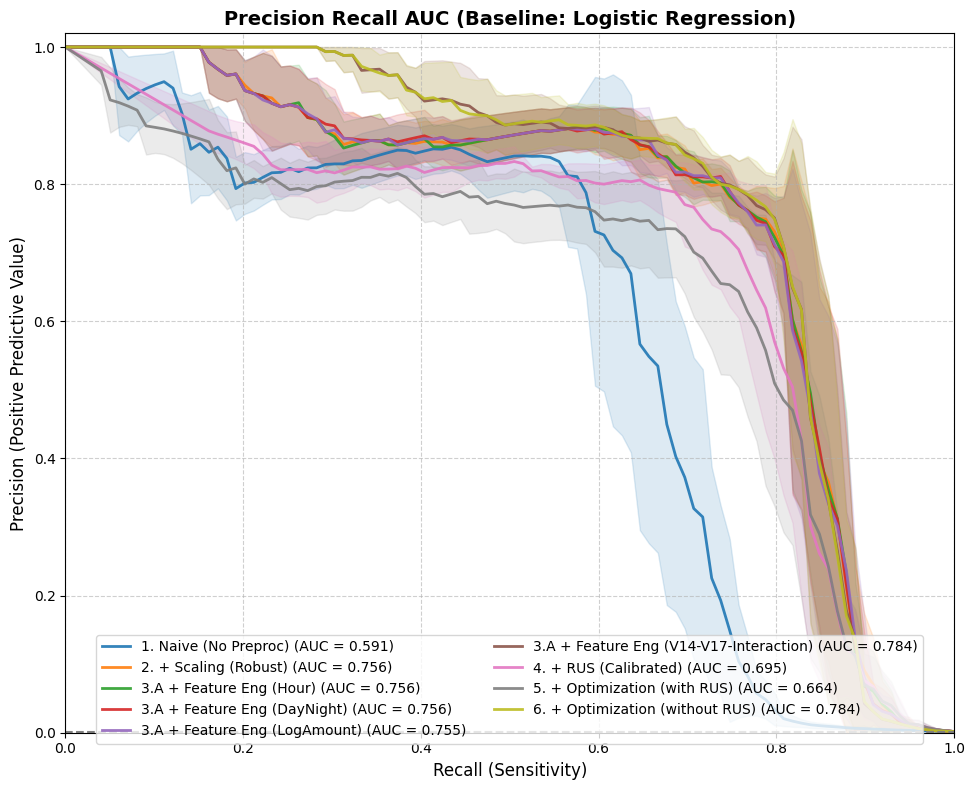

In [21]:
plot_pr_curves_with_std(plot_data, title="Precision Recall AUC (Baseline: Logistic Regression)")

In [ ]:
# We define distinct pipelines to test each component
configs = {
    "1. Naive (No Preproc)": {
        'scale': False, 'fe': False, 'rus': False, 'opt': False
    },
    "2. + Scaling (Robust)": {
        'scale': True, 'fe': False, 'rus': False, 'opt': False
    },
    "3. + Feature Eng (Hour)": {
        'scale': True, 'fe': True, 'rus': False, 'opt': False
    },
    "4. + RUS (Calibrated)": {
        'scale': True, 'fe': True, 'rus': True, 'opt': False
    },
    "5. + Optimization (with RUS)": {
        'scale': True, 'fe': True, 'rus': True, 'opt': True
    },
    "6. + Optimization (without RUS)": {
        'scale': True, 'fe': True, 'rus': False, 'opt': True
    }
}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class FraudFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Comprehensive Feature Engineering for Credit Card Fraud.

    Adds:
    1. Time Features: Hour, Is_Night
    2. Amount Features: Log_Amount, Amount_Decimal
    3. Interaction Features: V14 * V17 (based on EDA correlations)
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Applies transformations to X."""
        X_out = X.copy()

        # --- 1. Time Features ---
        if 'Time' in X_out.columns:
            # Hour (0-23)
            X_out['Hour'] = (X_out['Time'] % 86400) // 3600

            # Is_Night (Binary): 1 if between 22:00 and 06:00
            # Helping trees isolate nocturnal fraud patterns instantly
            X_out['Is_Night'] = (X_out['Hour'] >= 22) | (X_out['Hour'] <= 6)
            X_out['Is_Night'] = X_out['Is_Night'].astype(int)

        # --- 2. Amount Features ---
        if 'Amount' in X_out.columns:
            # Log Amount: Handles the extreme skew of transaction amounts
            # np.log1p avoids log(0) errors
            X_out['Log_Amount'] = np.log1p(X_out['Amount'])

            # Decimal Part: Captures pricing psychology (e.g., 9.99 vs 10.00)
            X_out['Amount_Dec'] = X_out['Amount'] % 1

        # --- 3. Interaction Features (Based on EDA) ---
        # V17 and V14 had the strongest correlations in your EDA.
        # Multiplying them helps trees find the "diagonal" decision boundary.
        if 'V14' in X_out.columns and 'V17' in X_out.columns:
            X_out['V14_V17'] = X_out['V14'] * X_out['V17']

        return X_out